In [1]:
# needs scikit-learn version >= 0.22 because of permutation_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from features import categorical_features, skewed_features, unskewed_features, cols_idxs

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df.shape

(2196, 55)

In [4]:
df_typo = df["typology"] # needed for stratification below

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 54)
y_train.shape = (1756,)
X_test.shape = (440, 54)
y_test.shape = (440,)


In [5]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
print("Dummy MAE = {:.3f}".format(mean_absolute_error(y_test, dummy.predict(X_test))))
# Dummy MAE = 0.315

Dummy MAE = 0.315


In [6]:
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

categorical_idxs = cols_idxs(df.drop(columns="po_value"), categorical_features)

preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = StandardScaler()
)

ridge = make_pipeline(preprocessor, Ridge())

ridge.fit(X_train, y_train)
ridge_test_pred = ridge.predict(X_test)
print("Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, ridge_test_pred)))
print("Ridge R^2 = {:.3f}".format(ridge.score(X_test, y_test)))

Ridge MAE = 0.169
Ridge R^2 = 0.695


In [7]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv = GridSearchCV(ridge, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Grid search / cross-validation:
Best alpha = 0.56
Best MAE = 0.177


In [8]:
gcv_test_pred = gcv.predict(X_test)
print("On test data:")
print("Tuned Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, gcv_test_pred)))
print("Tuned Ridge R^2 = {:.3f}".format(r2_score(y_test, gcv_test_pred)))

On test data:
Tuned Ridge MAE = 0.169
Tuned Ridge R^2 = 0.696


In [9]:
sns.set_style('whitegrid')
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)

    best_idx = valid_scores_mean.argmax()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

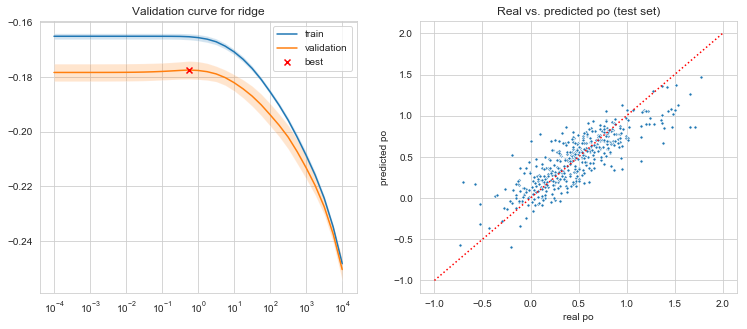

In [10]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, valid_scores = validation_curve(ridge, X_train, y_train, param_name="ridge__alpha",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge", param_range, train_scores, valid_scores, ax1)

sns.scatterplot(y_test, ridge_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

In [11]:
skewed_idxs = cols_idxs(df.drop(columns="po_value"), skewed_features)
unskewed_idxs = cols_idxs(df.drop(columns="po_value"), unskewed_features)

#print(set(df.columns) - set(["po_value"]) - set(categorical_features) - set(skewed_features) - set(unskewed_features))

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

ridge2 = make_pipeline(preprocessor, Ridge())

ridge2.fit(X_train, y_train)
ridge2_test_pred = ridge2.predict(X_test)
print("Ridge2 MAE = {:.3f}".format(mean_absolute_error(y_test, ridge2_test_pred)))
print("Ridge2 R^2 = {:.3f}".format(ridge2.score(X_test, y_test)))

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Ridge2 MAE = 0.156
Ridge2 R^2 = 0.746


In [12]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv2 = GridSearchCV(ridge2, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv2.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv2.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv2.best_score_))

Grid search / cross-validation:
Best alpha = 0.56
Best MAE = 0.166


C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [13]:
gcv2_test_pred = gcv2.predict(X_test)
print("On test data:")
print("Tuned Ridge2 MAE = {:.3f}".format(mean_absolute_error(y_test, gcv2_test_pred)))
print("Tuned Ridge2 R^2 = {:.3f}".format(r2_score(y_test, gcv2_test_pred)))

On test data:
Tuned Ridge2 MAE = 0.156
Tuned Ridge2 R^2 = 0.746


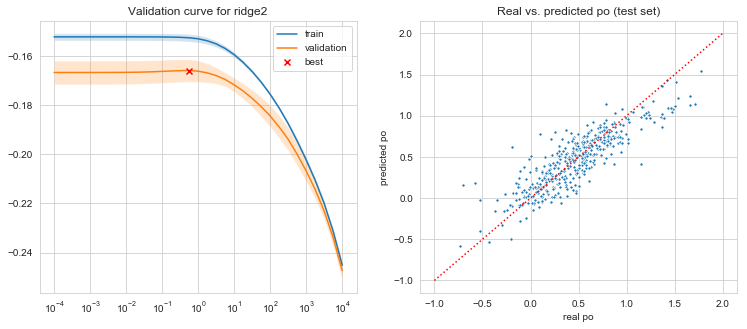

In [14]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, valid_scores = validation_curve(ridge2, X_train, y_train, param_name="ridge__alpha",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge2", param_range, train_scores, valid_scores, ax1)

sns.scatterplot(y_test, ridge2_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

# Feature importance

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#permutation-importance-with-multicollinear-or-correlated-features

In [15]:
preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

estimator = make_pipeline(preprocessor, Ridge(alpha=0.56, random_state=0))
estimator.fit(X_train, y_train)
result = permutation_importance(estimator, X_train, y_train, scoring='neg_mean_absolute_error',
                                n_repeats=10, n_jobs=12, random_state=0)


C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [16]:
perm_sorted_idx = result["importances_mean"].argsort()
importances_sorted = result["importances_mean"][perm_sorted_idx]
cols_sorted = df_train.drop(columns="po_value").columns[perm_sorted_idx]

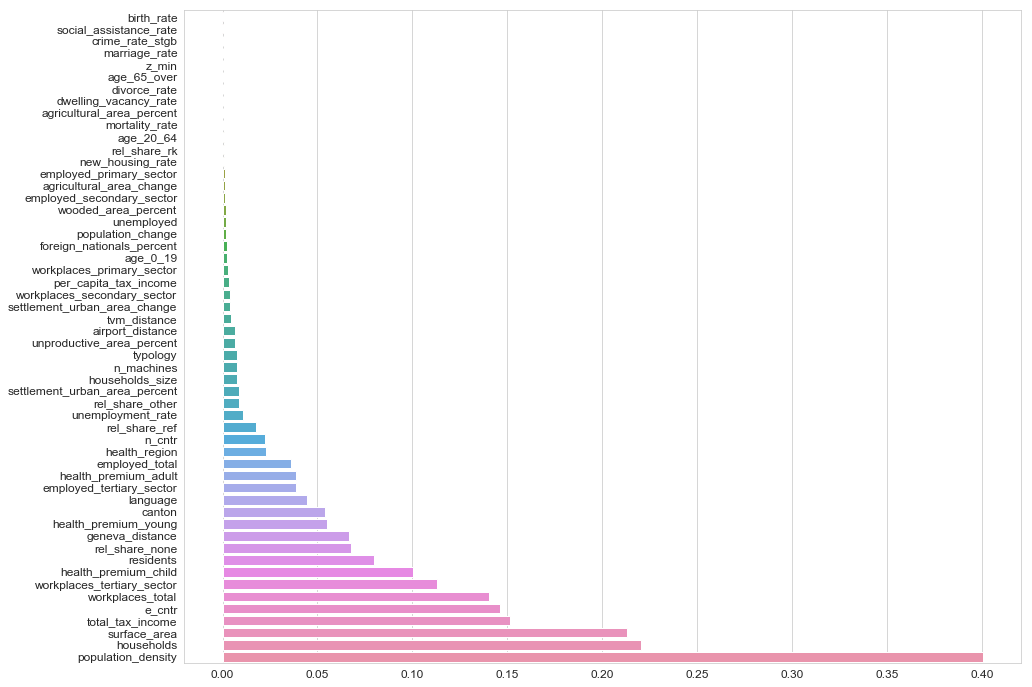

In [17]:
plt.figure(figsize = (15,12))
bp = sns.barplot(x=importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


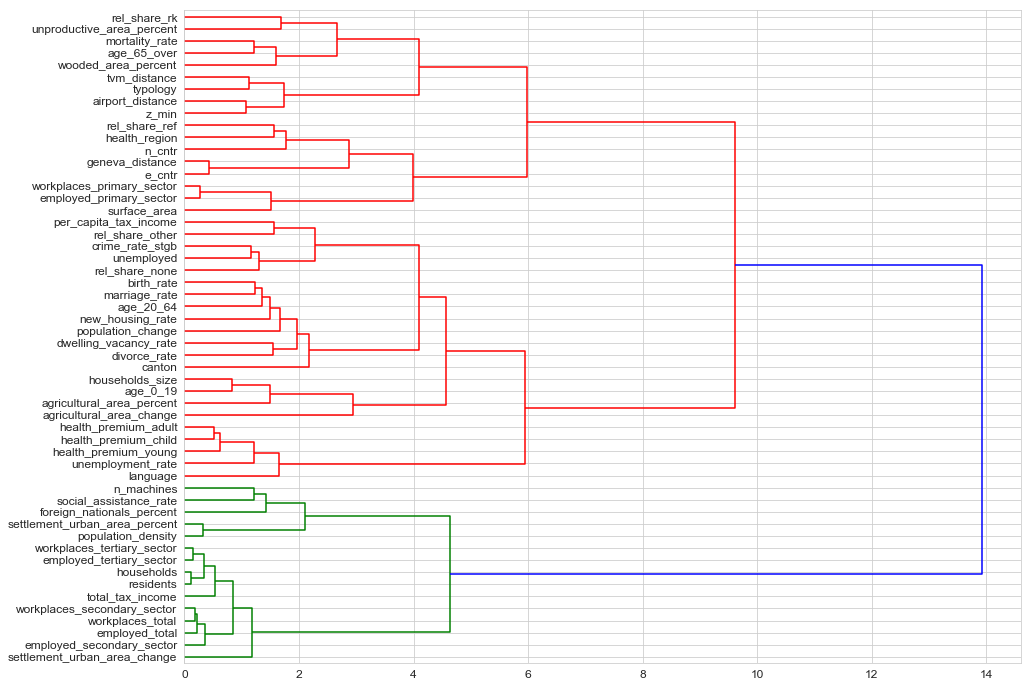

In [18]:
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
plt.figure(figsize = (15,12))
dendro = hierarchy.dendrogram(corr_linkage, labels=df_train.drop(columns="po_value").columns, orientation="right")
plt.gca().tick_params(labelsize="large")

## Reducing multicollinearities

## Funny cluster
- rel_share_rk 0.20
- unproductive_area_percent 0.07
- age_65_over 0.06
- mortality_rate 0.02
- wooded_area_percent 0.02

## Reachability cluster
- tvm_distance 0.20
- z_min 0.14
- airport_distance 0.06
- (typology)

## Location cluster
- e_cntr 0.47
- geneva_distance 0.46
- rel_share_ref 0.40
- health_region 0.38
- n_cntr 0.28

## Primary sector cluster
- workplaces_primary_sector 0.24
- employed_primary_sector 0.19
- surface_area 0.08

## Crime rate cluster
- rel_share_none 0.30
- crime_rate_stgb 0.29
- per_capita_tax_income 0.13
- rel_share_other 0.09
- unemployed 0.04

## Population change cluster
- population_change 0.16
- age_20_64 0.05 
- dwelling_vacancy_rate 0.05
- divorce_rate 0.05
- marriage_rate 0.04
- birth_rate 0.03
- new_housing_rate 0.02
- (canton)

## Agricultural area cluster
- agricultural_area_percent 0.15
- age_0_19 0.13
- household_size 0.06
- agricultural_area_change 0.02

## Health premium cluster
- health_premium_young 0.56
- unemployment_rate 0.55
- health_premium_child 0.53
- health_premium_adult 0.52
- (language)

### "Urbanity" cluster 
- foreign_nationals_percent 0.31
- settlement_urban_area_percent 0.28
- population_density 0.27
- social_assistance_rate 0.24 
- n_machines 0.17

### Residents cluster
- residents 0.18
- households 0.18
- workplaces_secondary_sector 0.18, employed_secondary_sector 0.18
- total_tax_income 0.17
- workplaces_tertiary_sector 0.16, employed_tertiary_sector 0.15
- workplaces_total 0.15, employed_total 0.15
- settlement_urban_area_change 0.13

In [19]:
reduced_features = [
    'rel_share_rk',
    'tvm_distance',
    'geneva_distance',
    'workplaces_primary_sector',
    'crime_rate_stgb',
    'population_change',
    'agricultural_area_percent',
    'health_premium_young',
    'foreign_nationals_percent',
    'residents',
    # categorical features
    'canton',
    'language',
    'typology',
]

X_train_red = df_train[reduced_features].values
X_test_red = df_test[reduced_features].values

categorical_features_red = set(categorical_features).intersection(set(reduced_features))
skewed_features_red = set(skewed_features).intersection(set(reduced_features))
unskewed_features_red = set(unskewed_features).intersection(set(reduced_features))

print("categorical_features_red =", categorical_features_red)
print("skewed_features_red =", skewed_features_red)
print("unskewed_features_red =", unskewed_features_red)

categorical_idxs_red = cols_idxs(df[reduced_features], categorical_features_red)
skewed_idxs_red = cols_idxs(df[reduced_features], skewed_features_red)
unskewed_idxs_red = cols_idxs(df[reduced_features], unskewed_features_red)

print("categorical_idxs_red = ", categorical_idxs_red)
print("skewed_idxs_red = ", skewed_idxs_red)
print("unskewed_idxs_red = ", unskewed_idxs_red)

categorical_features_red = {'language', 'typology', 'canton'}
skewed_features_red = {'residents', 'workplaces_primary_sector', 'tvm_distance'}
unskewed_features_red = {'foreign_nationals_percent', 'geneva_distance', 'rel_share_rk', 'health_premium_young', 'crime_rate_stgb', 'population_change', 'agricultural_area_percent'}
categorical_idxs_red =  [11, 12, 10]
skewed_idxs_red =  [9, 3, 1]
unskewed_idxs_red =  [8, 2, 0, 7, 4, 5, 6]


In [20]:
preprocessor_red = make_column_transformer(
    (OneHotEncoder(), categorical_idxs_red),
    (PowerTransformer(standardize=True), skewed_idxs_red),
    (StandardScaler(), skewed_idxs_red + unskewed_idxs_red),
    remainder = "passthrough"
)

ridge2_red = make_pipeline(preprocessor_red, Ridge())

parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv2_red = GridSearchCV(ridge2_red, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv2_red.fit(X_train_red, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.4f}".format(gcv2_red.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv2_red.best_score_))

Grid search / cross-validation:
Best alpha = 0.1000
Best MAE = 0.175


In [21]:
gcv2_red_test_pred = gcv2_red.predict(X_test_red)
print("On test data:")
print("Tuned Ridge2 (red.) MAE = {:.3f}".format(mean_absolute_error(y_test, gcv2_red_test_pred)))
print("Tuned Ridge2 (red.) R^2 = {:.3f}".format(r2_score(y_test, gcv2_red_test_pred)))

On test data:
Tuned Ridge2 (red.) MAE = 0.163
Tuned Ridge2 (red.) R^2 = 0.721


In [22]:
result = permutation_importance(gcv2_red, X_train_red, y_train, scoring='neg_mean_absolute_error', # neg_mean_absolute_error
                                n_repeats=10, n_jobs=12, random_state=0)

In [23]:
perm_sorted_idx = result["importances_mean"].argsort()
importances_sorted = result["importances_mean"][perm_sorted_idx]
cols_sorted = df[reduced_features].columns[perm_sorted_idx]

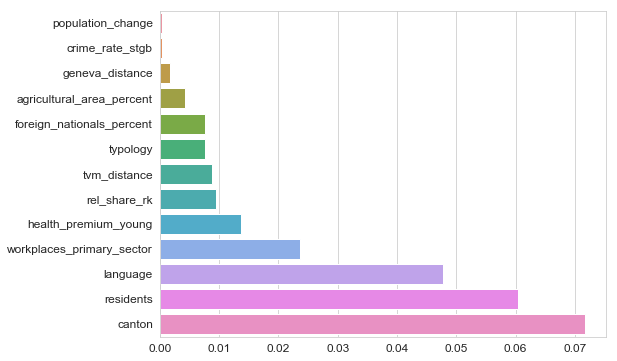

In [24]:
plt.figure(figsize = (8,6))
bp = sns.barplot(x=importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")